In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Créer un dossier pour le projet
import os
project_path = '/content/drive/MyDrive/DeepGuard'
os.makedirs(project_path, exist_ok=True)
os.chdir(project_path)

print(f"✅ Travail dans : {os.getcwd()}")

Mounted at /content/drive
✅ Travail dans : /content/drive/MyDrive/DeepGuard


In [ ]:
!git clone https://github.com/raniaamil/DeepGuard.git
%cd DeepGuard

fatal: destination path 'DeepGuard' already exists and is not an empty directory.
/content/drive/MyDrive/DeepGuard/DeepGuard


In [ ]:
# Désinstaller uniquement ce qui pose problème
!pip uninstall -y facenet-pytorch opencv-python albumentations
print("🗑️ Désinstallation terminée")

# Installer avec les versions ACTUELLES de Colab
!pip install -q facenet-pytorch==2.5.3
!pip install -q opencv-python==4.8.1.78
!pip install -q albumentations==1.3.1
!pip install -q matplotlib==3.8.2 seaborn==0.13.1

# NE PAS toucher à torch, numpy, pandas, scikit-learn (Colab les gère)
print("✅ Installations terminées - versions compatibles !")

# Vérifier
!pip list | grep -E "torch|opencv|facenet|albumentations"

Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
Found existing installation: albumentations 2.0.8
Uninstalling albumentations-2.0.8:
  Successfully uninstalled albumentations-2.0.8
🗑️ Désinstallation terminée
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 129.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of t

In [ ]:
# Teste que tout marche
import torch
import cv2
from facenet_pytorch import MTCNN, InceptionResnetV1
import albumentations as A
import numpy as np

print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ CUDA disponible: {torch.cuda.is_available()}")
print(f"✅ OpenCV: {cv2.__version__}")
print(f"✅ Facenet-PyTorch: OK")
print(f"✅ Albumentations: {A.__version__}")
print("\n🎉 Tout est prêt pour la reconnaissance faciale !")

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
import torch
import torchvision
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from tqdm import tqdm

# Configuration
%matplotlib inline
sns.set_style('whitegrid')

# Vérifier GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")

if torch.cuda.is_available():
    print(f"✅ GPU détecté : {torch.cuda.get_device_name(0)}")
    print(f"   Mémoire disponible : {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️  Pas de GPU détecté")

In [2]:
# Upload ton fichier kaggle.json
from google.colab import files

print("📤 Upload ton fichier kaggle.json (Account → Create New API Token)")
uploaded = files.upload()

# Configuration Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("✅ Kaggle configuré !")

📤 Upload ton fichier kaggle.json (Account → Create New API Token)


Saving kaggle.json to kaggle.json
✅ Kaggle configuré !


In [3]:
# Créer le dossier data
!mkdir -p data/raw

# Télécharger le dataset
!kaggle datasets download -d ciplab/real-and-fake-face-detection -p data/raw

# Dézipper
!unzip -q data/raw/real-and-fake-face-detection.zip -d data/raw/
!rm data/raw/real-and-fake-face-detection.zip

# Lister ce qu'on a
!ls -lh data/raw/

print("✅ Dataset téléchargé !")

Dataset URL: https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection
License(s): CC-BY-NC-SA-4.0
 93% 399M/431M [00:00<00:00, 515MB/s]
100% 431M/431M [00:00<00:00, 542MB/s]
total 8.0K
drwxr-xr-x 4 root root 4.0K Jan 13 17:16 real_and_fake_face
drwxr-xr-x 3 root root 4.0K Jan 13 17:16 real_and_fake_face_detection
✅ Dataset téléchargé !


In [4]:
import os
from pathlib import Path

# ✅ Chemin : on pointe directement vers UN seul dataset
data_root = Path("data/raw/real_and_fake_face")

def explore_directory(path: Path, max_files: int = 5) -> None:
    """Explore la structure du dataset (affiche quelques fichiers par dossier)."""
    for root, dirs, files in os.walk(path):
        level = root.replace(str(path), "").count(os.sep)
        indent = " " * 2 * level
        print(f"{indent}{os.path.basename(root)}/")

        sub_indent = " " * 2 * (level + 1)

        # Compter les fichiers par extension (sur l'échantillon affiché)
        extensions = {}
        for file in files[:max_files]:
            print(f"{sub_indent}{file}")
            ext = Path(file).suffix.lower()
            extensions[ext] = extensions.get(ext, 0) + 1

        if len(files) > max_files:
            print(f"{sub_indent}... et {len(files) - max_files} autres fichiers")

        if extensions:
            print(f"{sub_indent}Total par type (échantillon): {extensions}")
        print()

# ▶️ Exécution
explore_directory(data_root)


real_and_fake_face/

  training_real/
    real_00870.jpg
    real_01017.jpg
    real_00827.jpg
    real_00734.jpg
    real_00467.jpg
    ... et 1076 autres fichiers
    Total par type (échantillon): {'.jpg': 5}

  training_fake/
    easy_52_1100.jpg
    mid_360_1100.jpg
    hard_206_0001.jpg
    mid_431_0001.jpg
    easy_183_1111.jpg
    ... et 955 autres fichiers
    Total par type (échantillon): {'.jpg': 5}



In [5]:
from pathlib import Path

# ✅ Adapter selon la structure réelle du dataset téléchargé
# Structure confirmée :
# data/raw/real_and_fake_face/
# ├── training_real/
# └── training_fake/

data_root = Path("data/raw/real_and_fake_face")

# Exemple probable (c'est le bon dans ton cas)
training_real_path = data_root / 'training_real'
training_fake_path = data_root / 'training_fake'

# Compter les images
def count_images(path):
    """Compte les images dans un dossier"""
    if not path.exists():
        return 0
    return len([f for f in path.glob('*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']])

num_real = count_images(training_real_path)
num_fake = count_images(training_fake_path)

print(f"📊 Statistiques du dataset :")
print(f"   Images réelles : {num_real}")
print(f"   Images fake : {num_fake}")
print(f"   Total : {num_real + num_fake}")
print(f"   Balance : {num_real/(num_real+num_fake)*100:.1f}% réelles / {num_fake/(num_real+num_fake)*100:.1f}% fake")

# Vérifier la balance
if abs(num_real - num_fake) / max(num_real, num_fake) < 0.1:
    print("   ✅ Dataset bien balancé !")
else:
    print("   ⚠️  Dataset déséquilibré, il faudra gérer ça")


📊 Statistiques du dataset :
   Images réelles : 1081
   Images fake : 960
   Total : 2041
   Balance : 53.0% réelles / 47.0% fake
   ⚠️  Dataset déséquilibré, il faudra gérer ça


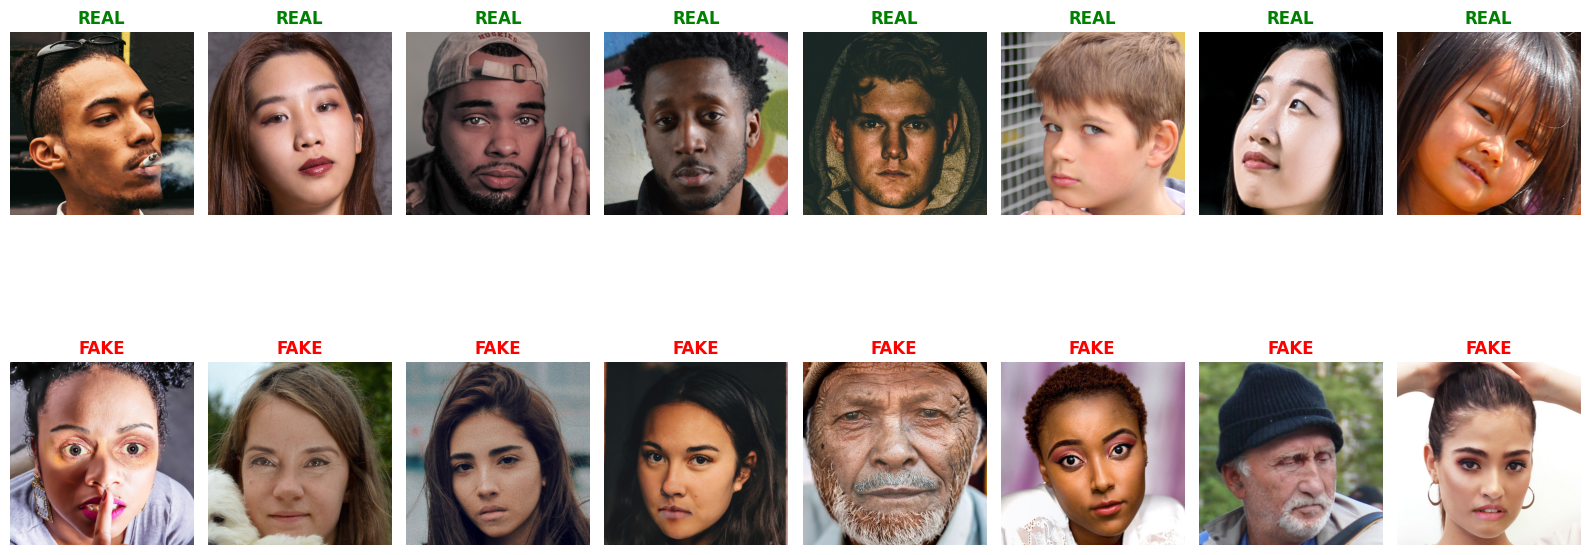

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

def show_sample_images(real_path, fake_path, n_samples=8, figsize=(16, 8)):

    # Créer la grille
    fig, axes = plt.subplots(2, n_samples, figsize=figsize)

    # Lister les images
    real_images = list(real_path.glob('*'))[:n_samples]
    fake_images = list(fake_path.glob('*'))[:n_samples]

    # Afficher les vraies images
    for i, img_path in enumerate(real_images):
        img = Image.open(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title('REAL', color='green', fontsize=12, fontweight='bold')
        axes[0, i].axis('off')

    # Afficher les fausses images
    for i, img_path in enumerate(fake_images):
        img = Image.open(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title('FAKE', color='red', fontsize=12, fontweight='bold')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Afficher
show_sample_images(training_real_path, training_fake_path)


In [8]:
from PIL import Image
import numpy as np
from tqdm import tqdm

def analyze_image_properties(path, sample_size=100):

    images = list(path.glob('*'))[:sample_size]

    widths = []
    heights = []
    aspects = []
    sizes_kb = []

    for img_path in tqdm(images, desc=f"Analyse {path.name}"):
        try:
            img = Image.open(img_path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
            aspects.append(w / h)

            # Taille en KB
            size_kb = img_path.stat().st_size / 1024
            sizes_kb.append(size_kb)
        except Exception as e:
            print(f"Erreur avec {img_path.name}: {e}")

    return {
        'width_mean': np.mean(widths),
        'width_std': np.std(widths),
        'width_min': np.min(widths),
        'width_max': np.max(widths),
        'height_mean': np.mean(heights),
        'height_std': np.std(heights),
        'height_min': np.min(heights),
        'height_max': np.max(heights),
        'aspect_mean': np.mean(aspects),
        'size_kb_mean': np.mean(sizes_kb),
        'size_kb_max': np.max(sizes_kb),
        'sizes_kb': sizes_kb,
        'widths': widths,
        'heights': heights
    }

# Analyser les deux catégories
print("Analyse des images REAL...")
real_props = analyze_image_properties(training_real_path)

print("\nAnalyse des images FAKE...")
fake_props = analyze_image_properties(training_fake_path)

# Afficher les résultats
print("\n" + "="*60)
print("📊 PROPRIÉTÉS DES IMAGES")
print("="*60)

print("\n🟢 REAL images:")
print(f"   Résolution moyenne : {real_props['width_mean']:.0f} x {real_props['height_mean']:.0f}")
print(f"   Résolution min : {real_props['width_min']:.0f} x {real_props['height_min']:.0f}")
print(f"   Résolution max : {real_props['width_max']:.0f} x {real_props['height_max']:.0f}")
print(f"   Aspect ratio moyen : {real_props['aspect_mean']:.2f}")
print(f"   Taille fichier moyenne : {real_props['size_kb_mean']:.1f} KB")

print("\n🔴 FAKE images:")
print(f"   Résolution moyenne : {fake_props['width_mean']:.0f} x {fake_props['height_mean']:.0f}")
print(f"   Résolution min : {fake_props['width_min']:.0f} x {fake_props['height_min']:.0f}")
print(f"   Résolution max : {fake_props['width_max']:.0f} x {fake_props['height_max']:.0f}")
print(f"   Aspect ratio moyen : {fake_props['aspect_mean']:.2f}")
print(f"   Taille fichier moyenne : {fake_props['size_kb_mean']:.1f} KB")

Analyse des images REAL...


Analyse training_real: 100%|██████████| 100/100 [00:00<00:00, 12402.58it/s]



Analyse des images FAKE...


Analyse training_fake: 100%|██████████| 100/100 [00:00<00:00, 12584.17it/s]


📊 PROPRIÉTÉS DES IMAGES

🟢 REAL images:
   Résolution moyenne : 600 x 600
   Résolution min : 600 x 600
   Résolution max : 600 x 600
   Aspect ratio moyen : 1.00
   Taille fichier moyenne : 112.0 KB

🔴 FAKE images:
   Résolution moyenne : 600 x 600
   Résolution min : 600 x 600
   Résolution max : 600 x 600
   Aspect ratio moyen : 1.00
   Taille fichier moyenne : 102.7 KB


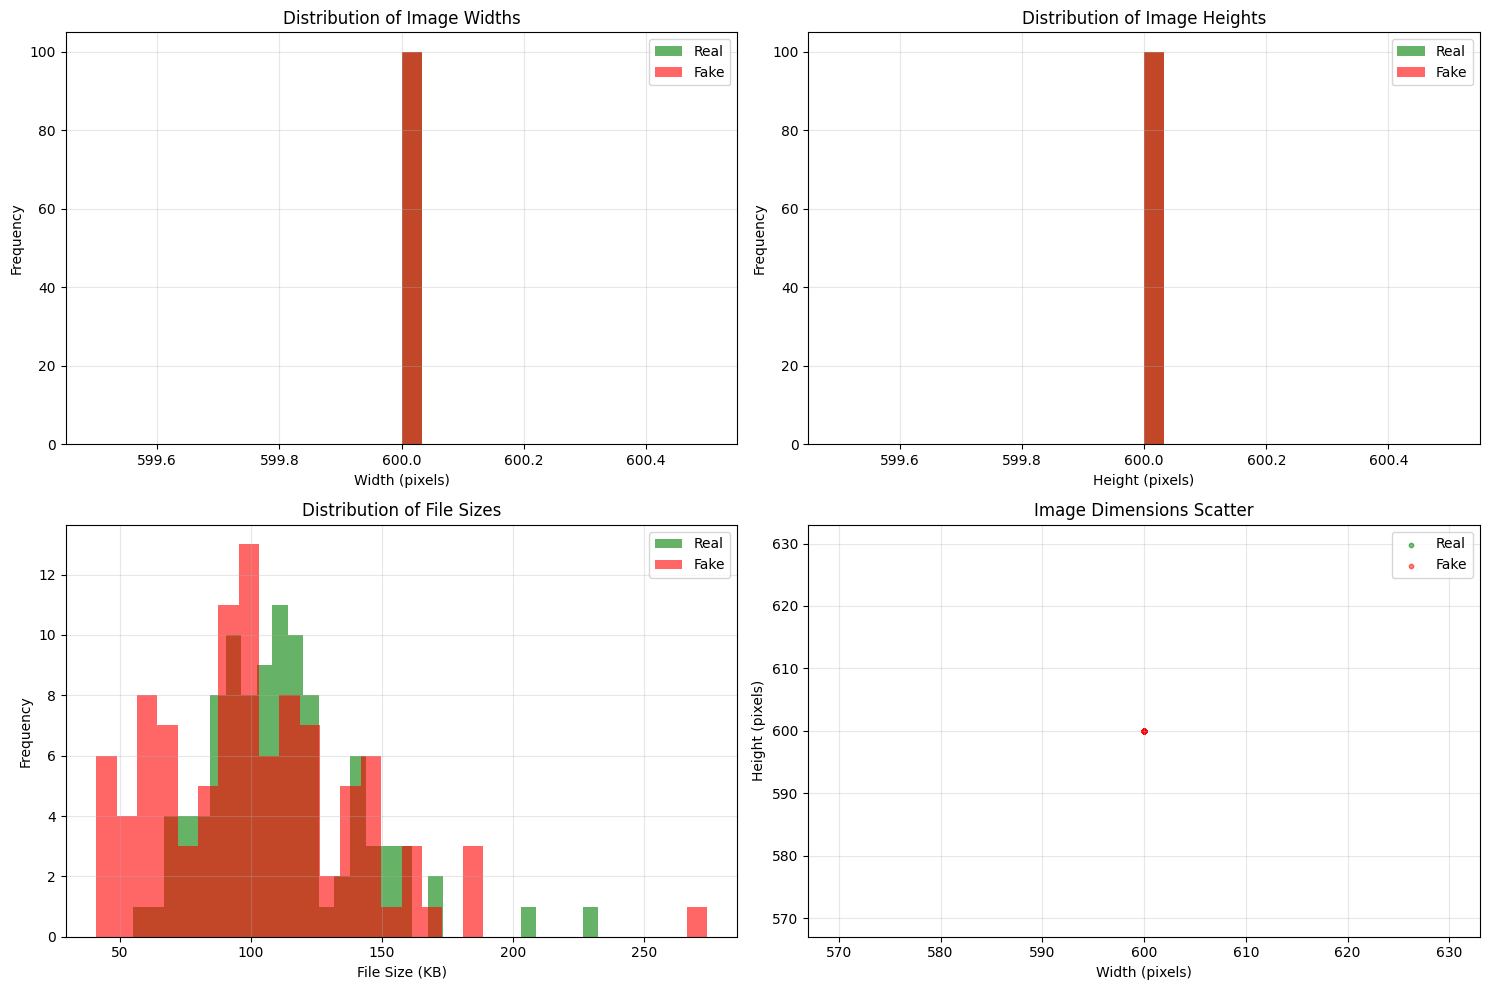

In [9]:
# Créer les visualisations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution des largeurs
axes[0, 0].hist(real_props['widths'], bins=30, alpha=0.6, label='Real', color='green')
axes[0, 0].hist(fake_props['widths'], bins=30, alpha=0.6, label='Fake', color='red')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Image Widths')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Distribution des hauteurs
axes[0, 1].hist(real_props['heights'], bins=30, alpha=0.6, label='Real', color='green')
axes[0, 1].hist(fake_props['heights'], bins=30, alpha=0.6, label='Fake', color='red')
axes[0, 1].set_xlabel('Height (pixels)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Image Heights')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Distribution des tailles de fichiers
axes[1, 0].hist(real_props['sizes_kb'], bins=30, alpha=0.6, label='Real', color='green')
axes[1, 0].hist(fake_props['sizes_kb'], bins=30, alpha=0.6, label='Fake', color='red')
axes[1, 0].set_xlabel('File Size (KB)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of File Sizes')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Scatter plot Width vs Height
axes[1, 1].scatter(real_props['widths'], real_props['heights'], alpha=0.5, label='Real', color='green', s=10)
axes[1, 1].scatter(fake_props['widths'], fake_props['heights'], alpha=0.5, label='Fake', color='red', s=10)
axes[1, 1].set_xlabel('Width (pixels)')
axes[1, 1].set_ylabel('Height (pixels)')
axes[1, 1].set_title('Image Dimensions Scatter')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [1]:
# Télécharger le notebook
from google.colab import files

# Sauvegarder localement
notebook_name = '01_setup_and_eda.ipynb'
files.download(notebook_name)

print(f"✅ Télécharge {notebook_name} et déplace-le dans le dossier notebooks/ de ton repo local")

FileNotFoundError: Cannot find file: 01_setup_and_eda.ipynb